Idea: When B stabilizes, the topics will be stable and hence G will be comparable.

We perform many iterations and verify B converges.

After B converges, we take the graphs from those iterations and choose the most frequent one.

In [1]:
from const import globs
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

In [2]:
# GLOBAL VARIABLES. BE SURE NOT TO OVERWRITE THEM

D, V, M, k, gamma = globs('l')

From now on let's use the following simulated data for further testing

In [13]:
from simulator import Simulator
from samplers import MC_sample_Z, MC_sample_B, MC_sample_H, MC_sample_GK
from transformation_functions import update_Theta, update_Sigma, update_E, update_C
from generator_functions import sample_Z_from_W
from binder_loss import binder_loss
from graph_loss import permutation_topics, graph_loss

# 4. MAIN CYCLE

### Generating Target Data

These data will be used as input (matrix Z and W) and target (matrix G) for our simulation. 

In [4]:
simulated_data = Simulator(D, V, M, k, gamma, seed=1888)
simulated_data.generate_all_data()

Success: Sigma transformed from K
Success: G transformed from K
Success: W and Z generated
Success: E transformed from Z
Success: C transformed from Z


In [5]:
# Input Data:
simulated_data.W

array([[2., 1., 3., ..., 5., 2., 0.],
       [3., 3., 2., ..., 2., 4., 2.],
       [1., 1., 1., ..., 2., 2., 0.],
       ...,
       [0., 2., 0., ..., 1., 0., 1.],
       [2., 2., 0., ..., 2., 1., 3.],
       [2., 1., 0., ..., 1., 2., 3.]])

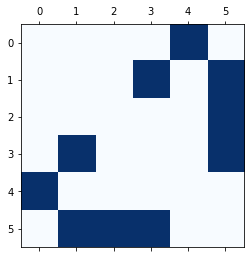

In [6]:
# Target graph
plt.matshow(simulated_data.G, cmap='Blues')

### Generating Uninformative Initial Data

These are used as our initial guess for Sigma, K, B, Theta and G

Success: G transformed from K
Success: E transformed from Z
Success: C transformed from Z


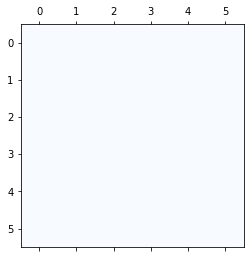

In [7]:
# Initial guesses
initial_uninf = Simulator(D, V, M, k, gamma, 2020)
initial_uninf.generate_non_informative(simulated_data.W)

# Initial graph
plt.matshow(initial_uninf.G, cmap='Blues')

## Global Sampler

All objects are updated within the cycle.

In [14]:
%%time
max_iterations = 5000
np.random.seed(25041945)

# Initialization
Sigma = initial_uninf.Sigma.copy()
K = np.linalg.inv(Sigma)
B = initial_uninf.B.copy()
Theta = initial_uninf.Theta.copy()
G = initial_uninf.G.copy()

alpha = np.ones(V)  # Uninformative prior
b = k - 1

Z = initial_uninf.Z.copy()  # Random sample of Z based on actual data: Done in generator

E = initial_uninf.E.copy()  # Transformation of Z: Done in generator
C = initial_uninf.C.copy()  # Transformation of Z: Done in generator

H = initial_uninf.H.copy()
step = 0.5

# Metrics

Zerrors1 = []
Zconv = []

Berrors1 = []
B_converge1 = [] 
perms = []

waiting_times1 = []
sampled_Gs1 = []
graph_changes1 = []
edges_log1 = []
errors_log1 = []
graph_losses1 = []

for iteration in range(max_iterations):
    
    # Step 1
    last_Z = Z.copy()
    Z, E, C = MC_sample_Z(Z, simulated_data.W, Theta, B, E, C, debug=True)
    Zerrors1.append(binder_loss(Z, simulated_data.Z))
    Zconv.append(binder_loss(Z, last_Z))
    
    # Step 2
    last_B = B.copy()
    B = MC_sample_B(alpha, C)
    B_converge1.append(np.linalg.norm(B - last_B))
    
    err_by_it = []
    for topic in range(k):
        err_by_it.append(np.linalg.norm(B[topic] - last_B[topic]))  # Computing error wrt the target distribution  # BUG https://trello.com/c/uEYV7fSC/32-mcsampleb-shape-mismatch
    Berrors1.append(err_by_it)
    
    permute = permutation_topics(B_true=simulated_data.B, B_sampled=B)
    perms.append(permute)
    
    # Step 3
    H, step = MC_sample_H(E, Sigma, K, step_size=step, H_current=H, burn_in=15)
    Theta = update_Theta(Theta, H)  # get Theta from H
    
    # Step 4    
    G_old = G.copy()
    wt_sample, G_new, K = MC_sample_GK(G, H, b, debug=False)
    
    graph_changes1.append(~np.all(G_new == G_old))
    
    G = G_new
    Sigma = np.linalg.inv(K)
    
    waiting_times1.append(wt_sample)
    sampled_Gs1.append(G.copy())
    
    wrong_edges = np.sum(G != simulated_data.G)
    error = np.linalg.norm(Sigma - simulated_data.Sigma)
    edges_log1.append(wrong_edges)
    errors_log1.append(error)
    
    graph_loss = graph_loss(G_true=simulated_data.G, G_sampled=G, permutation=permute)
    graph_losses1.append(graph_loss)
    
    if iteration%100==0:
        print('Now at iteration '+str(iteration)+'/'+str(max_iterations))
    
# NOTE: Should perform 500 iterations every 7 minutes
# If it takes longer, RESTART, it could have gotten stuck in the R part

[0.0, 1.0, 2.0, 3.0, 4.0, 5.0]
14
Now at iteration 0/5000
[0.0, 1.0, 2.0, 3.0, 4.0, 5.0]


TypeError: 'numpy.int64' object is not callable

B convergence metrics
count    5000.000000
mean        0.344217
std         0.059613
min         0.146731
25%         0.306680
50%         0.342741
75%         0.382136
max         0.620698
dtype: float64


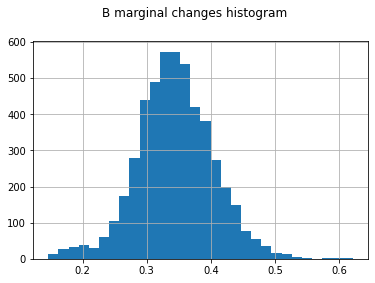

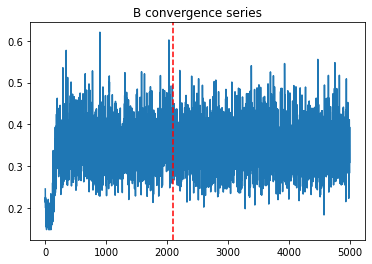

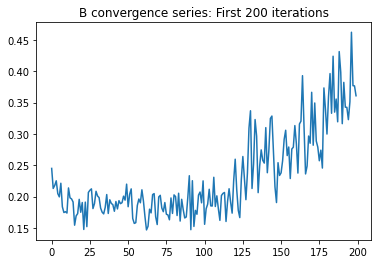

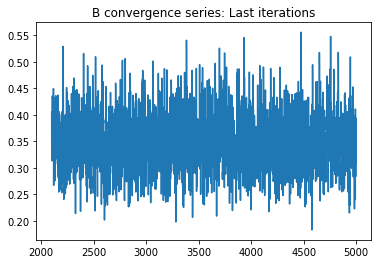

In [25]:
B_conv = pd.Series(B_converge1)

print("B convergence metrics")
print(B_conv.describe())

B_conv.hist(bins=30)  # Should look like an exponential decay?
plt.suptitle('B marginal changes histogram', x=0.5, y=1, ha='center')
plt.show()

B_conv.plot(title="B convergence series")
cut = 1000  # It will be a standard burn in
plt.axvline(x=cut, color='red', linestyle='--')
plt.show()

B_conv[0:cut].plot(title="B convergence series: First iterations")
plt.show()

B_conv[cut:].plot(title="B convergence series: Last iterations")
plt.show()

Z binder loss metrics
count    5000.000000
mean        0.021037
std         0.000476
min         0.016599
25%         0.021091
50%         0.021111
75%         0.021127
max         0.021233
dtype: float64


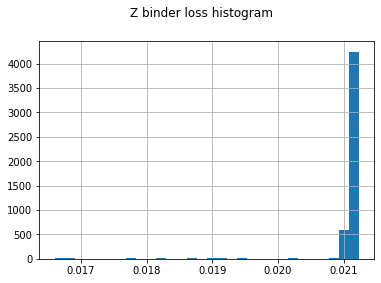

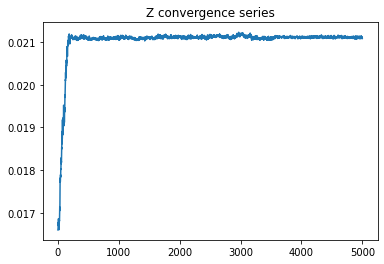

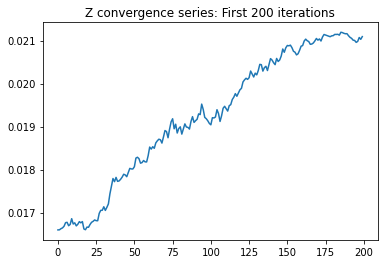

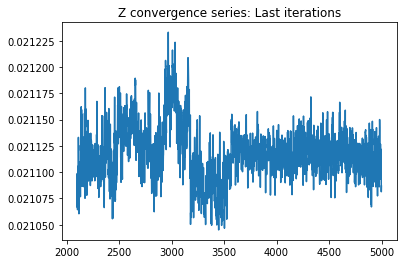

In [26]:
errors = pd.Series(Zerrors1)
print("Z binder loss metrics")
print(errors.describe())
errors.hist(bins=30)
plt.suptitle('Z binder loss histogram', x=0.5, y=1, ha='center')
plt.show()

errors.plot(title="Z convergence series")  # See if we still have a caterpillar
plt.axvline(x=cut, color='red', linestyle='--')
plt.show()

errors[0:cut].plot(title="Z convergence series: First iterations")
plt.show()

errors[cut:].plot(title="Z convergence series: Last iterations")
plt.show()

B L2-error metrics
count    5000.000000
mean        0.021037
std         0.000476
min         0.016599
25%         0.021091
50%         0.021111
75%         0.021127
max         0.021233
dtype: float64


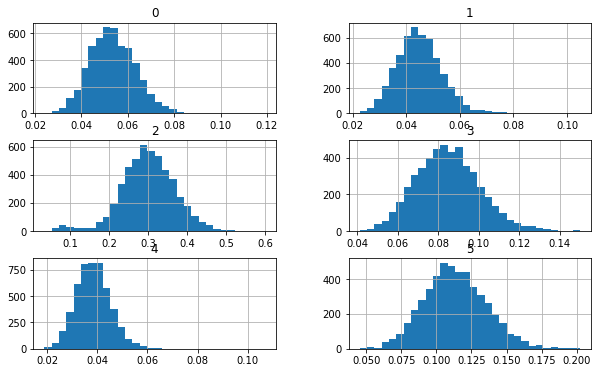

B L2-error series


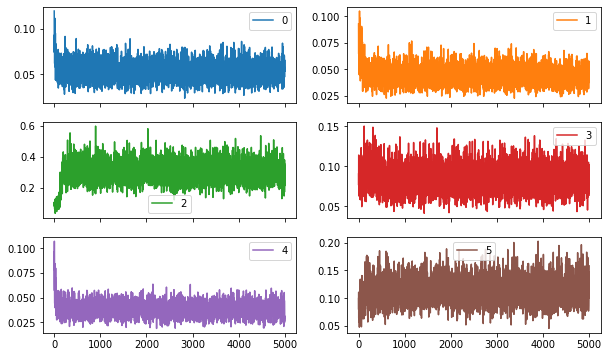

B L2-error series: First 200 iterations


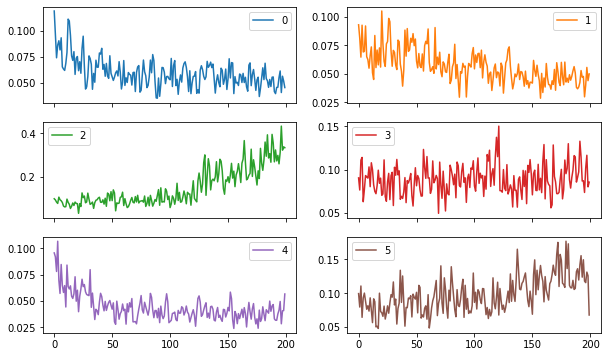

B L2-error series: Last iterations


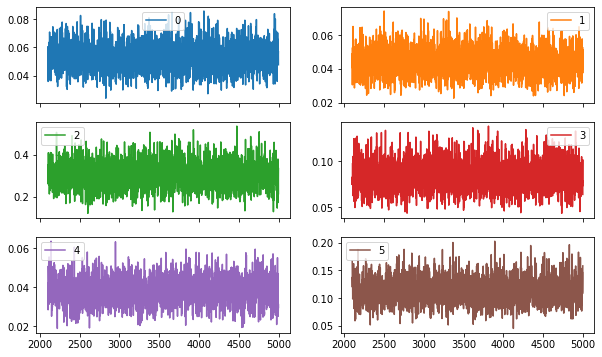

In [27]:
Berrors = pd.DataFrame(Berrors1)
print("B L2-error metrics")
print(errors.describe())

Berrors.hist(bins=30, layout=(3,2), figsize=(10, 6))
plt.show()

print('B L2-error series')
Berrors.plot(subplots=True, layout=(3,2), figsize=(10, 6))
plt.show()

print('B L2-error series: First iterations')
Berrors[0:cut].plot(subplots=True, layout=(3,2), figsize=(10, 6))
plt.show()

print('B L2-error series: Last iterations')
Berrors[cut:].plot(subplots=True, layout=(3,2), figsize=(10, 6))
plt.show()

G matrix changes (1 = changed, 0 = same)
count    5000.000000
mean        0.395200
std         0.488943
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
dtype: float64


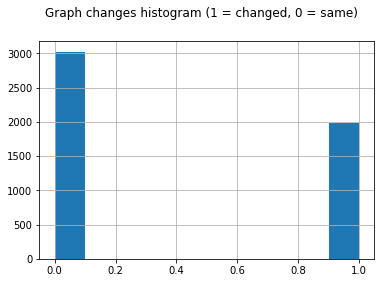

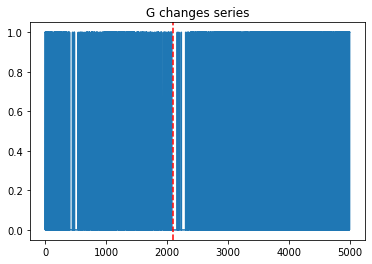

In [28]:
matrix_changes = pd.Series(graph_changes1).astype(int)

print("G matrix changes (1 = changed, 0 = same)")
print(matrix_changes.describe())

matrix_changes.hist()
plt.suptitle("Graph changes histogram (1 = changed, 0 = same)", x=0.5, y=1, ha='center')
plt.show()

matrix_changes.plot(title='G changes series')
plt.axvline(x=cut, color='red', linestyle='--')
plt.show()

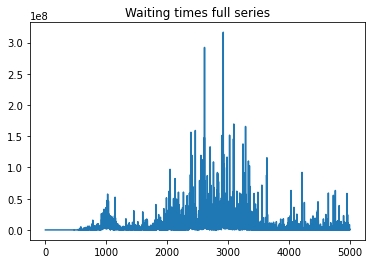

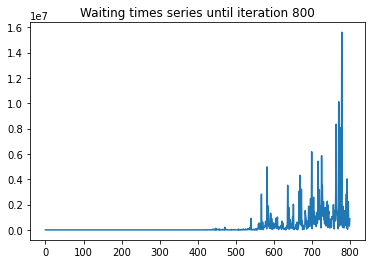

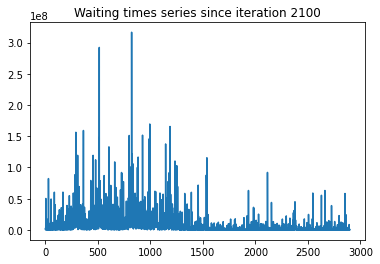

In [31]:
wait_times_full = pd.Series(waiting_times1)
wait_times_full.plot(title="Waiting times full series")
plt.axvline(x=cut, color='red', linestyle='--')
plt.show()

wait_times_init = pd.Series(waiting_times1[0:cut])
wait_times_init.plot(title="Waiting times series until iteration"+str(cut))
plt.show()

wait_times_cut = pd.Series(waiting_times1[cut:])
wait_times_cut.plot(title="Waiting times series since iteration "+str(cut))
plt.show()

Wrong edges metrics
count    5000.000000
mean       10.819200
std         1.686144
min         6.000000
25%        10.000000
50%        10.000000
75%        10.000000
max        14.000000
dtype: float64


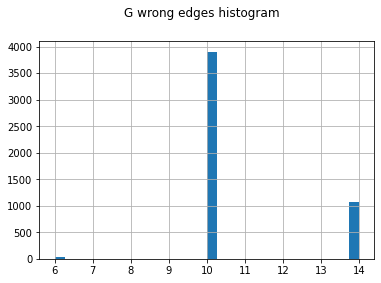

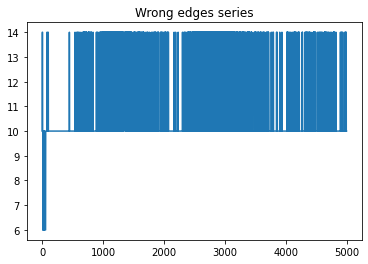

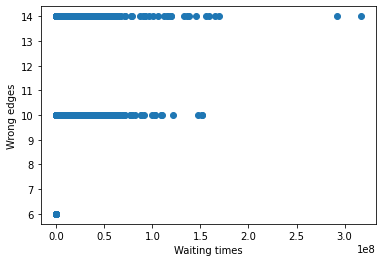

In [36]:
wrong_edges = pd.Series(edges_log1)

print("Wrong edges metrics")
print(wrong_edges.describe())

wrong_edges.hist(bins=30)
plt.suptitle('G wrong edges histogram', x=0.5, y=1, ha='center')
plt.show()

wrong_edges.plot(title="Wrong edges series")
plt.axvline(x=cut, color='red', linestyle='--')
plt.show()

plt.scatter(wait_times_full, wrong_edges)
plt.xlabel('Waiting times')
plt.ylabel('Wrong edges')
plt.show()

Sigma errors metrics
count    5.000000e+03
mean     1.277100e+12
std      1.296979e+12
min      1.778617e+01
25%      4.233549e+10
50%      6.936656e+11
75%      2.701861e+12
max      4.603668e+12
dtype: float64


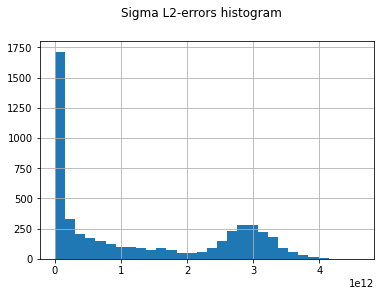

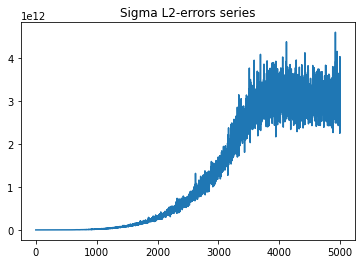

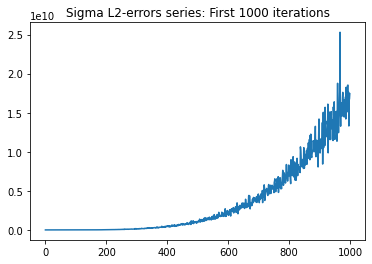

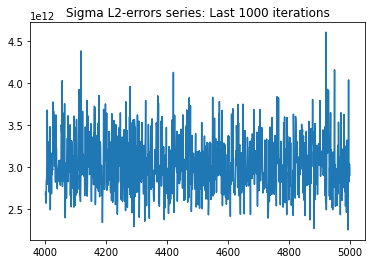

In [35]:
Sigma_errors = pd.Series(errors_log1)

print("Sigma errors metrics")
print(Sigma_errors.describe())

Sigma_errors.hist(bins=30)
plt.suptitle('Sigma L2-errors histogram', x=0.5, y=1, ha='center')
plt.show()

Sigma_errors.plot(title="Sigma L2-errors series")
plt.axvline(x=cut, color='red', linestyle='--')
plt.show()

Sigma_errors[0:1000].plot(title="Sigma L2-errors series: First 1000 iterations")
plt.show()

Sigma_errors[4000:5000].plot(title="Sigma L2-errors series: Last 1000 iterations")
plt.show()

In [ ]:
graph_loss = pd.Series(graph_losses1)

print("Graph loss metrics")
print(graph_loss.describe())

graph_loss.hist(bins=30)
plt.suptitle('G graph loss histogram', x=0.5, y=1, ha='center')
plt.show()

graph_loss.plot(title="Graph loss series")
plt.axvline(x=cut, color='red', linestyle='--')
plt.show()

graph_loss[0:cut].plot(title="Waiting times series until iteration"+str(cut))
plt.show()

graph_loss[cut:].plot(title="Waiting times series since iteration "+str(cut))
plt.show()

plt.scatter(wait_times_full, graph_loss)
plt.xlabel('Waiting times')
plt.ylabel('Graph losses')
plt.show()

### Final alternative

a) Last graph

In [8]:
import pickle

with open('2022-02-09_1107_sampled_Gs.pkl', 'rb') as f:  # opens a file in read byte mode 
    sampled_Gs = pickle.load(f)

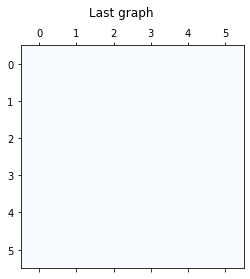

In [9]:
plt.matshow(sampled_Gs[-1], cmap='Blues')
plt.suptitle("Last graph", x=0.5, y=1, ha='center')
plt.show()

b) Binder loss

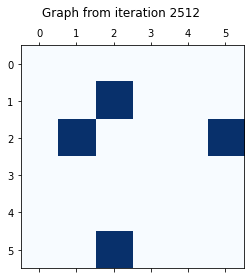

In [23]:
with open('2022-02-08_2243_Zerrors.pkl', 'rb') as f:  # opens a file in read byte mode 
    Zerrors = pickle.load(f)

opt1 = np.argmin(Zerrors[1000:])

plt.matshow(sampled_Gs[opt1], cmap='Blues')
plt.suptitle("Graph from iteration "+str(opt1+1000), x=0.5, y=1, ha='center')
plt.show()

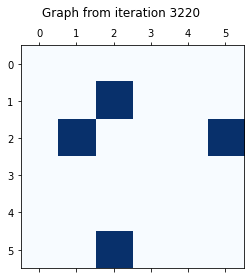

In [24]:
opt2 = np.argmin(Zerrors[3000:])

plt.matshow(sampled_Gs[opt2], cmap='Blues')
plt.suptitle("Graph from iteration "+str(opt2+3000), x=0.5, y=1, ha='center')
plt.show()

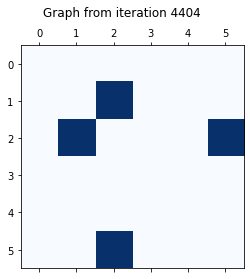

In [25]:
opt3 = np.argmin(Zerrors[4000:])

plt.matshow(sampled_Gs[opt3], cmap='Blues')
plt.suptitle("Graph from iteration "+str(opt3+4000), x=0.5, y=1, ha='center')
plt.show()

c) Most sampled graphs

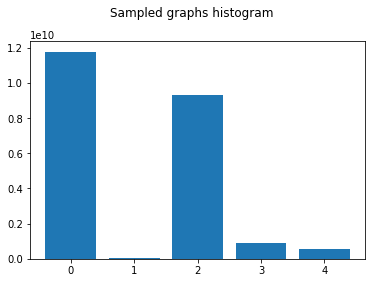

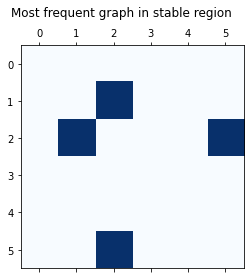

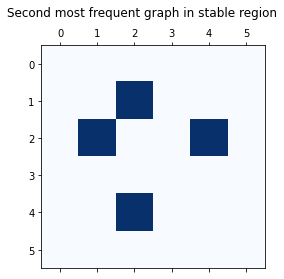

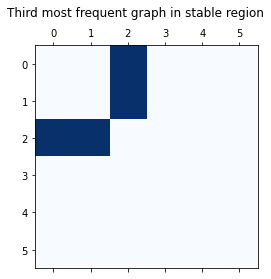

In [29]:
graphs = []
counts = []
not_found = True
for it in range(cut,max_iterations):
    not_found = True
    for j in range(len(graphs)):
        if np.all(sampled_Gs1[it] == graphs[j]):
            counts[j] += waiting_times1[it]
            not_found = False
    if not_found:
        graphs.append(sampled_Gs1[it])
        counts.append(waiting_times1[it])

plt.bar(range(len(counts)),counts)
plt.suptitle('Sampled graphs histogram', x=0.5, y=1, ha='center')
plt.show()

modes = pd.Series(counts).sort_values()

plt.matshow(graphs[counts.index(modes[0])], cmap='Blues')
plt.suptitle("Most frequent graph in stable region", x=0.5, y=1, ha='center')
plt.show()

plt.matshow(graphs[counts.index(modes[1])], cmap='Blues')
plt.suptitle("Second most frequent graph in stable region", x=0.5, y=1, ha='center')
plt.show()

plt.matshow(graphs[counts.index(modes[2])], cmap='Blues')
plt.suptitle("Third most frequent graph in stable region", x=0.5, y=1, ha='center')
plt.show()

#### Data dumping

In [37]:
from datetime import datetime as dt
import pickle

In [38]:
timestamp = dt.now().strftime("%Y-%m-%d_%H%M")  # by minute

filename = 'Zerrors.pkl'
with open(timestamp + '_' + filename, 'wb+') as f:  # opens a (new) file in write byte mode 
    pickle.dump(Zerrors1, f)

filename = 'Z_by_iter.pkl'
with open(timestamp + '_' + filename, 'wb+') as f:  # opens a (new) file in write byte mode 
    pickle.dump(Zconv, f)
    
filename = 'Berrors.pkl'
with open(timestamp + '_' + filename, 'wb+') as f:  # opens a (new) file in write byte mode 
    pickle.dump(Berrors1, f)

filename = 'B_converge.pkl'
with open(timestamp + '_' + filename, 'wb+') as f:  # opens a (new) file in write byte mode 
    pickle.dump(B_converge1, f)

filename = 'Permutations.pkl'
with open(timestamp + '_' + filename, 'wb+') as f:  # opens a (new) file in write byte mode 
pickle.dump(perms, f)
    
filename = 'waiting_times.pkl'
with open(timestamp + '_' + filename, 'wb+') as f:  # opens a (new) file in write byte mode 
    pickle.dump(waiting_times1, f)
    
filename = 'sampled_Gs.pkl'
with open(timestamp + '_' + filename, 'wb+') as f:  # opens a (new) file in write byte mode 
    pickle.dump(sampled_Gs1, f)
    
filename = 'graph_changes.pkl'
with open(timestamp + '_' + filename, 'wb+') as f:  # opens a (new) file in write byte mode 
    pickle.dump(graph_changes1, f)
    
filename = 'edges_log.pkl'
with open(timestamp + '_' + filename, 'wb+') as f:  # opens a (new) file in write byte mode 
    pickle.dump(edges_log1, f)
    
filename = 'errors_log.pkl'
with open(timestamp + '_' + filename, 'wb+') as f:  # opens a (new) file in write byte mode 
    pickle.dump(errors_log1, f)

filename = 'graph_losses.pkl'
with open(timestamp + '_' + filename, 'wb+') as f:  # opens a (new) file in write byte mode 
    pickle.dump(graph_losses1, f)